In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import os
os.chdir("/workspace/Brain2CLIP_Diffusion_v3")
!pip install -r requirements.txt
!pip install accelerate
!pip install --upgrade diffusers

!pip install umap
!pip install fastparquet
!pip install spkit

!pip install --upgrade torchtext
!pip install pytorch-lightning==1.8.3.post0
!pip3 install torch torchvision torchaudio

!pip3 install torch torchvision torchaudio

## Importing Libraries

!pip install mxnet-cu112
!pip install numpy==1.23

Remember that in runpod sometimes jupyter only sees libraries installed outside envs. 

Try numpy 1.22 if it does not work.

In [3]:
import torch

In [4]:
import mxnet

In [5]:
import os
import sys
import torch
from typing import Tuple, Union
from mxnet import nd, symbol
from mxnet.gluon.nn import HybridBlock
from mxnet.gluon.parameter import Parameter
from mxnet.initializer import Zero
from mxnet.gluon.nn import Conv2D, HybridSequential, LeakyReLU, Dense
from mxnet import nd, gluon, autograd
import mxnet as mx
from mxnet.io import NDArrayIter
import typing

In [6]:
from transformers import CLIPFeatureExtractor, CLIPModel
from sklearn.linear_model import LinearRegression, SGDClassifier, SGDRegressor

In [7]:
from sklearn.linear_model import Ridge
import pickle
import pandas as pd
from mxnet import nd
from mxnet.io import NDArrayIter
from mxnet.symbol import Symbol
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

sys.path.append("/workspace/Brain2CLIP_Diffusion_v3/lambda_diffusers")

os.chdir("/workspace/Brain2CLIP_Diffusion_v3/lambda_diffusers/pipelines")

from pipelines.pipeline_stable_diffusion_im_embed import CLIPImageEncoder, StableDiffusionFromLatents
from PIL import Image

## Loading Hyper


In [8]:
def load_dataset(t, x, batch_size):
    return NDArrayIter({ "x": nd.stack(*x, axis=0) }, { "t": nd.stack(*t, axis=0) }, batch_size, True)

subject = 1
batch_size = 30

with open("/workspace/hyper/data/data_%i.dat" % subject, 'rb') as f:
          X_tr, T_tr, X_te, T_te = pickle.load(f)
          train = load_dataset(nd.array(T_tr), nd.array(X_tr), batch_size)        
          test =  load_dataset(nd.array(T_te), nd.array(X_te), batch_size=36)  

In [9]:
class Linear(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units=n_in))


class Pixelnorm(HybridBlock):
    def __init__(self, epsilon: float = 1e-8) -> None:
        super(Pixelnorm, self).__init__()
        self.epsilon = epsilon

    def hybrid_forward(self, F, x) -> nd:
        return x * F.rsqrt(F.mean(F.square(x), 1, True) + self.epsilon)


class Bias(HybridBlock):
    def __init__(self, shape: Tuple) -> None:
        super(Bias, self).__init__()
        self.shape = shape
        with self.name_scope():
            self.b = self.params.get("b", init=Zero(), shape=shape)

    def hybrid_forward(self, F, x, b) -> nd:
        return F.broadcast_add(x, b[None, :, None, None])


class Block(HybridSequential):
    def __init__(self, channels: int, in_channels: int) -> None:
        super(Block, self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        with self.name_scope():
            self.add(Conv2D(channels, 3, padding=1, in_channels=in_channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(channels, 3, padding=1, in_channels=channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())

    def hybrid_forward(self, F, x) -> nd:
        x = F.repeat(x, 2, 2)
        x = F.repeat(x, 2, 3)
        for i in range(len(self)):
            x = self[i](x)
        return x


In [10]:

class Generator(HybridSequential):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        with self.name_scope():
            self.add(Pixelnorm())
            self.add(Dense(8192, use_bias=False, in_units=512))
            self.add(Bias((512,)))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(512, 3, padding=1, in_channels=512))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            
            self.add(Block(512, 512)) # 8
            self.add(Block(512, 512))
            self.add(Block(512, 512))
            self.add(Block(256, 512))
            self.add(Block(128, 256))
            self.add(Block(64, 128))
            self.add(Block(32, 64))
            self.add(Block(16, 32)) # 15
            self.add(Conv2D(3, 1, in_channels=16))

    
    def hybrid_forward(self, F: Union[nd.NDArray, Symbol], x: nd, layer: int) -> nd:
        x = F.Reshape(self[1](self[0](x)), (-1, 512, 4, 4))
        for i in range(2, len(self)):
            x = self[i](x)
            if i == layer + 7:
              return x
        return x

In [11]:
generator = Generator()
generator.load_parameters("/workspace/hyper/data/generator.params")

#### Check if face generation from gan latents works

In [12]:
face = generator(train.label[0][1][77][None], 9).asnumpy()

In [13]:
train.label[0][1].shape

(1050, 512)

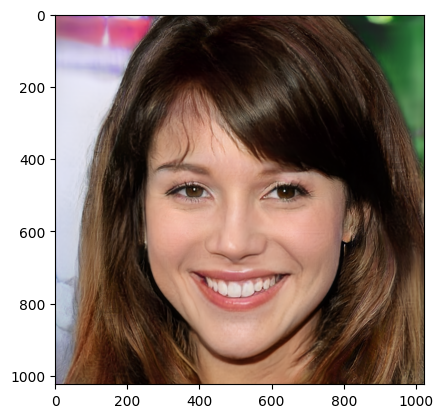

In [14]:
face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
face = face.astype("uint8")
face = face.transpose(0, 2, 3, 1)
face = Image.fromarray(face[0], 'RGB')
plt.imshow(face)

### Create CLIP latents by decoding face with GAN (512) and re-encoding it with CLIP (768)

In [15]:
def createCLIPLatents(hyper_latents):
    
    sd_pipe = CLIPImageEncoder(CLIPModel, CLIPFeatureExtractor) #check from pretrained
    
    latents = []
    
    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
            ),
        transforms.Normalize(
        [0.48145466, 0.4578275, 0.40821073],
        [0.26862954, 0.26130258, 0.27577711]),
        transforms.ToPILImage()
    ])
        
    
    
    for hyper_latent in hyper_latents[0][1]:
        
        face = generator(hyper_latent[None], 9).asnumpy()
        
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        face = Image.fromarray(face[0], 'RGB')
        
        face = tform(face)   #!!!!!!!!!!!!!!!!
        
        clip_latent = sd_pipe(face)
      
        latents.append([hyper_latent, clip_latent])
        
        
    return latents
        
        
        
    

In [16]:
# latents = createCLIPLatents(train.label)

In [17]:
latents = np.load("/workspace/latents/clip_latents.npy", allow_pickle = True)
latents = np.array(latents)


c_latents = np.zeros((1050,768))

for i,latent in enumerate(latents[:,1]):

    c_latents[i,:] = latent[0][0].numpy()
    
c_latents.shape



(1050, 768)

## Order correctly since they get shuffled every time

In [18]:
gan_latents = np.array(train.label)[0][1].asnumpy()

/tmp/ipykernel_106891/170351298.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gan_latents = np.array(train.label)[0][1].asnumpy()


In [19]:
brain_data = train.data[0][1]

In [23]:
type(latents[0])

numpy.ndarray

In [24]:
type(latents[0][5])

IndexError: index 5 is out of bounds for axis 0 with size 2

In [21]:
clip_latents = np.zeros((1050,768))

for i, gan_latent in enumerate(gan_latents):
    
    for c_latent in latents[0]:
        print(type(c_latent), type(gan_latent))
        if c_latent == gan_latent:
            clip_latents[i] = c_latent
    
    

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'numpy.ndarray'>


TypeError: type <class 'numpy.ndarray'> not supported

In [ ]:
latents[0][0].shape

(512,)

In [ ]:
brain_data.shape

(1050, 4096)

In [ ]:
# Fit Linear regression
reg = LinearRegression().fit(brain_data.asnumpy(),clip_latents)

### Check if it works

In [ ]:
brain_data_tensor = torch.from_numpy(brain_data.asnumpy())
reconstruction = reg.predict(brain_data_tensor[10:20])
reconstruction.shape

(10, 768)

## First images from brain data with stable diffusion!

In [ ]:
import inspect
import warnings
from typing import List, Optional, Union
from torchvision import transforms

import torch
import PIL

import numpy
from transformers import CLIPFeatureExtractor, CLIPModel

from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

In [ ]:
from pipelines.pipeline_stable_diffusion_im_embed import CLIPImageEncoder, StableDiffusionFromLatents, StableDiffusionImageEmbedPipeline
from pipelines.pipeline_stable_diffusion_im_embed import StableDiffusionImageEmbedPipeline as vanilla_diffusion
from PIL import Image

In [ ]:
tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
            ),
        transforms.Normalize(
        [0.48145466, 0.4578275, 0.40821073],
        [0.26862954, 0.26130258, 0.27577711]),
        transforms.ToPILImage()
    ])

In [ ]:
#Load modified code for stable diffusion (img2img, changed in order to accept directly the latents)

device = "cuda:0"
stable_diffusion = StableDiffusionFromLatents.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  )

stable_diffusion = stable_diffusion.to('cuda')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
stable_diffusion = stable_diffusion.to('cuda')
#stable_diffusion2 = stable_diffusion2.to('cuda')

In [ ]:
face_brain_data = torch.tensor(test.data[0][1].asnumpy())
face_clip_latents = reg.predict(face_brain_data)
face_clip_latents = torch.from_numpy(face_clip_latents).to('cuda')
face_gan_latents = test.label[0][1]

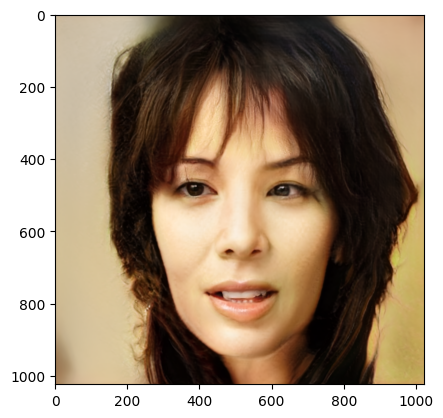

In [ ]:
face = generator(test.label[0][1][23][None], 9).asnumpy()
face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
face = face.astype("uint8")
face = face.transpose(0, 2, 3, 1)
face = Image.fromarray(face[0], 'RGB')

plt.imshow(face)
face = tform(face) # IMPORTANT !!!!!!!

In [ ]:
predictions = reg.predict(test.data[0][1][23:24].asnumpy())
predictions.shape

(1, 768)

In [ ]:
reconstructed_face = stable_diffusion(torch.from_numpy(predictions)[0].to('cuda'), guidance_scale = 5, num_inference_steps=50)

/workspace/Brain2CLIP_Diffusion_v3/lambda_diffusers/pipelines/pipeline_stable_diffusion_im_embed.py:141: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)


  0%|          | 0/51 [00:00<?, ?it/s]

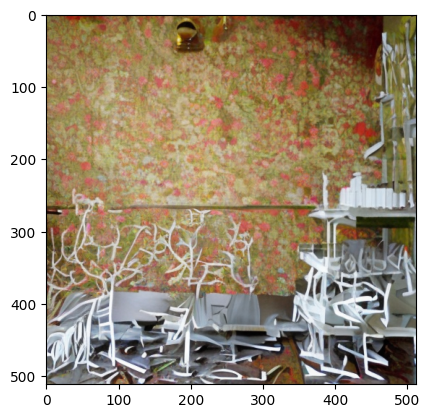

In [ ]:
plt.imshow(reconstructed_face["sample"][0])

In [ ]:
def make_examples(test, reg, num_examples):

    for i, gan_face in enumerate(test.label[0][1]):
        
        os.mkdir(f"/workspace/outputs/faces/test_{i}")
        
        
        face = generator(gan_face[None], 9).asnumpy()
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        face = Image.fromarray(face[0], 'RGB')
        face = tform(face) # IMPORTANT !!!
        face.save(f"/workspace/outputs/faces/test_{i}/GAN.jpg")
        
        
        # test.data is fmri data
        # the :i+1 just adds an empty dimension.
        fmri = test.data[0][1][i:i+1].asnumpy()
        clip_latents = torch.from_numpy(reg.predict(fmri)).to('cuda')
        
        for j in range(num_examples):
            
            std_face = stable_diffusion(clip_latents[0], guidance_scale = 5)["sample"][0]
            std_face.save(f"/workspace/outputs/faces/test_{i}/std_{j}.jpg")
            
        print(i, end=" ")
        
    

In [ ]:
make_examples(test, reg, 10)

NameError: name 'test' is not defined

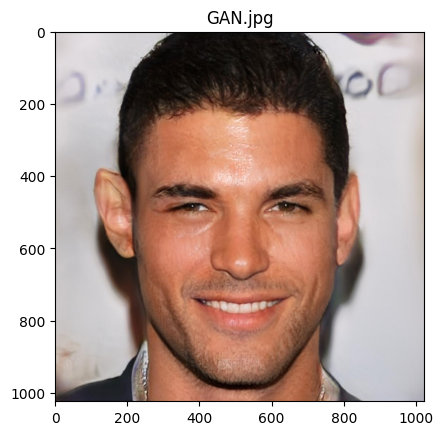

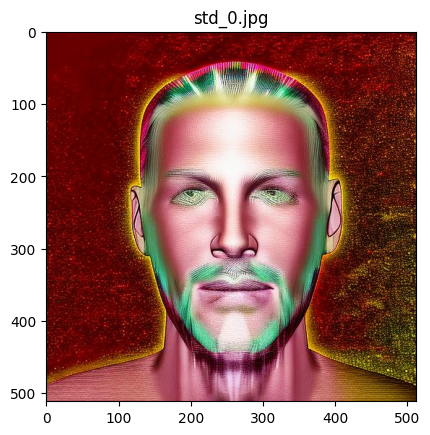

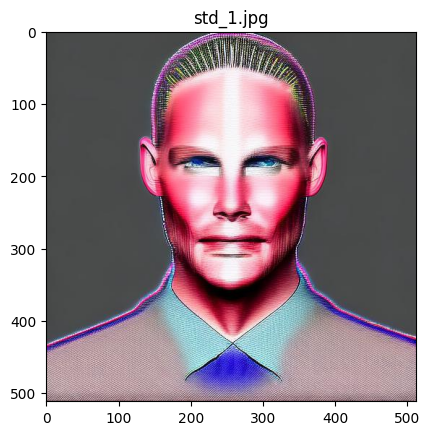

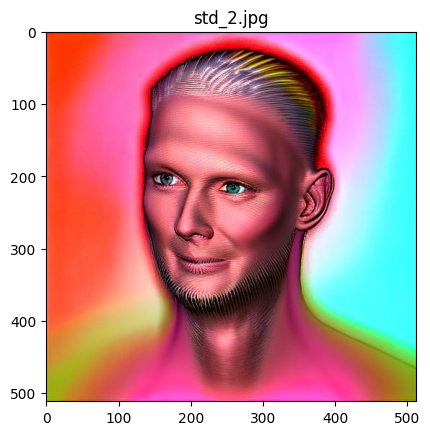

In [ ]:
for _im in os.listdir("/workspace/outputs/faces/test_1"):
    im = Image.open(f"/workspace/outputs/faces/test_1/{_im}")
    plt.imshow(im)
    plt.title(_im)
    plt.show()
    